In [1]:
from hypersurface import *
import sympy as sp
from pprint import pprint
from scipy.optimize import minimize
from sympy.utilities.iterables import flatten
import math

In [2]:
z0, z1, z2, z3, z4= sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5
HS = Hypersurface(Z, f, 1000)

In [3]:
HS.set_k(1)
ns = HS.n_sections

In [4]:
# holomorphic=True by default
factor = (HS.integrate(lambda patch, point: patch.omega_omegabar(point), numerical=True) / \
          HS.integrate(lambda patch, point: patch.num_FS_volume_form('identity', point), numerical=True)).real

The factor can be a build-in attribute and calculated patchwise. Design a function HS.calculate_factor() and call it before num_eta()

In [5]:
def flat_to_matrix(g_flat):
    g_real = g_flat[:len(g_flat)//2].reshape(ns, ns)
    g_imag = g_flat[len(g_flat)//2:].reshape(ns, ns)
    g_matrix = g_real + 1j * g_imag
    return g_matrix

In [6]:
def integration(g_flat):    
    g = flat_to_matrix(g_flat)
    h = g*np.conj(g.transpose())
    integration = HS.integrate(lambda patch, point, h_matrix=h: 
                                np.absolute(patch.num_eta(h_matrix, point)*factor - 1).real, 
                                holomorphic=True, numerical=True)
    return integration

The first matrix is the real part and second is the imaginary part.

In [47]:
#g0 = np.concatenate((np.ones(ns**2), np.ones(ns**2)),axis=None)*math.sqrt(1/2)
g0 = np.concatenate((np.identity(ns), np.identity(ns)), axis=None)*math.sqrt(1/2)
noise_real = np.tril((2 * np.random.rand(ns,ns) - 1) - 1)
noise_imag = np.tril((2 * np.random.rand(ns,ns) - 1) - 1)
noise = np.concatenate((noise_real, noise_imag), axis=None)*0.1
g0 = g0 + noise

array([[ 0.54893113+0.69624627j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [-0.03685523-0.16643681j,  0.60329633+0.61240102j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [-0.02809236-0.00604751j, -0.10880818-0.04515878j,
         0.58724089+0.59924057j,  0.        +0.j        ,
         0.        +0.j        ],
       [-0.02169798-0.10577065j, -0.09381794-0.16279239j,
        -0.05255769-0.12593752j,  0.59494558+0.64994527j,
         0.        +0.j        ],
       [-0.0367801 -0.15881992j, -0.12220197-0.04313179j,
        -0.15869268-0.06818117j, -0.14387829-0.03627877j,
         0.54902259+0.66683871j]])


In [34]:
res = minimize(integration, g0, method='L-BFGS-B')

In [35]:
g_minimal = res.x

In [36]:
g = flat_to_matrix(g_minimal)
h_minimal = g*np.conj(g.transpose())

In [23]:
HS.integrate(lambda patch, point, h_matrix='identity': 
                np.absolute(patch.num_eta(h_matrix, point)*factor - 1), 
                holomorphic=True, numerical=True)

(0.4726107430536371+1.6481306624358407e-19j)

In [37]:
HS.integrate(lambda patch, point, h_matrix=h_minimal: 
                np.absolute(patch.num_eta(h_matrix, point)*factor - 1), 
                holomorphic=True, numerical=True)

(0.44627994656202785+6.11104552754623e-20j)

In [39]:
print(h_minimal)

array([[ 0.93629413+0.j        , -0.00593158-0.00357687j,
        -0.01996295+0.02215865j, -0.02342705+0.02850052j,
        -0.09516071+0.0408923j ],
       [-0.00593158+0.00357687j,  0.90208932+0.j        ,
         0.04769967+0.0649709j ,  0.07642622+0.03263009j,
         0.04159054+0.02337678j],
       [-0.01996295-0.02215865j,  0.04769967-0.0649709j ,
         0.94741492+0.j        , -0.0239642 +0.01144173j,
         0.01833808-0.02746173j],
       [-0.02342705-0.02850052j,  0.07642622-0.03263009j,
        -0.0239642 -0.01144173j,  1.00479369+0.j        ,
         0.02995708-0.01302054j],
       [-0.09516071-0.0408923j ,  0.04159054-0.02337678j,
         0.01833808+0.02746173j,  0.02995708+0.01302054j,
         0.95921871+0.j        ]])


In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

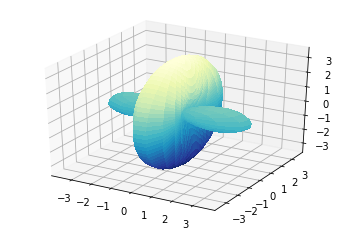

In [43]:
patch = HS.patches[0].patches[0]
theta, phi = np.linspace(0.0001,np.pi+0.0001, 40), np.linspace(0.0001, 2*np.pi+0.0001, 40)
R = []
for j in phi:
    theta_list = []
    for i in theta:
        t = complex(math.sin(i)*math.sin(j), math.cos(i))/(sin(i)*cos(j)) 
        if np.absolute(t) <= 1:
            eta = patch.num_eta(h_minimal, [1, -1, t, 0, -t])
        else:
            eta = patch.num_eta(h_minimal,[1, -1, 1/t, 0, -1/t])
        theta_list.append(eta)
    R.append(theta_list)
R = np.asarray(R)
THETA, PHI = np.meshgrid(theta, phi)
X = R * np.sin(THETA) * np.cos(PHI)
Y = R * np.sin(THETA) * np.sin(PHI)
Z = R * np.cos(THETA)
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r,
    linewidth=0, antialiased=False)